# Per-Image Metrics Analysis

This notebook analyzes `per_image_metrics.csv` files saved by the PaDiM experiment for each class. It computes per-class summary statistics (normal vs anomalous), visualizes distributions and relationships, runs statistical tests, and exports summary CSVs and figures.

Notebook outline:

1. Import libraries and config
2. Load CSV and quick preview
3. Preprocess
4. Split normal vs anomalous
5. Per-class summary stats
6. Distributions & KDEs
7. Boxplots & violins
8. Means with error bars
9. Scatter relationships
10. Correlations & heatmaps
11. Statistical tests
12. ROC & AUC
13. Export summaries and figures

Adjust `results_root` below to point to your results folder.

In [2]:
# Section 1: Imports and config
import os
import glob
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Notebook display config
%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set the results root to the folder that contains class subfolders
# Change this path as needed
results_root = Path('./results/256_color_profile_1')
output_dir = results_root / 'analysis_outputs'
output_dir.mkdir(parents=True, exist_ok=True)
print('Results root:', results_root)


Results root: results/256_color_profile_1


## Section 2: Discover per-class CSVs and quick preview
The notebook will look for `per_image_metrics.csv` inside each subfolder of `results_root` (for example `.../color_profile_1/<class>/per_image_metrics.csv`). For each class it will load the CSV and print a quick preview and counts.

In [14]:
# Find per-class CSVs
class_csv_paths = list(results_root.glob('*/per_image_metrics.csv'))
print('Found', len(class_csv_paths), 'class CSVs')

class_dfs = {}
for csv_path in class_csv_paths:
    class_name = csv_path.parent.name
    print('\nLoading class:', class_name, '->', csv_path)
    df = pd.read_csv(csv_path)
    print('Shape:', df.shape)
    display(df.head())
    print('gt_label counts:\n', df['gt_label'].value_counts(dropna=False).to_dict())
    print('pred_label counts:\n', df['pred_label'].value_counts(dropna=False).to_dict())
    class_dfs[class_name] = df

if not class_dfs:
    print('No per_image_metrics.csv files found under', results_root)


Found 1 class CSVs

Loading class: color_profile_1 -> results/256_color_profile_1/color_profile_1/per_image_metrics.csv
Shape: (108, 22)


,filepath,gt_label,pred_label,score,max,mean_top1pct,p95,mean,median,std,...,frac_above,threshold,num_components,largest_cc_area,largest_cc_frac,mean_cc_area,bbox_area,centroid_x,centroid_y,centroid_dist
0,/home/mikeszklarz/dev/lanl/anomaly_detection/d...,0,1,0.369795,0.369795,0.276789,0.192436,0.127235,0.124158,0.040518,...,0.008957,0.231459,3,549.0,0.008377,195.666667,7622,134.742099,131.328000,7.518742
1,/home/mikeszklarz/dev/lanl/anomaly_detection/d...,0,0,0.343071,0.343071,0.249944,0.185715,0.127194,0.122995,0.032898,...,0.006500,0.231459,6,230.0,0.003510,71.000000,65536,128.424819,124.731008,3.296479
2,/home/mikeszklarz/dev/lanl/anomaly_detection/d...,0,0,0.213067,0.213067,0.184825,0.146333,0.095078,0.094844,0.030045,...,0.000000,0.231459,0,0.0,0.000000,0.000000,0,NaN,NaN,NaN
3,/home/mikeszklarz/dev/lanl/anomaly_detection/d...,0,0,0.260399,0.260399,0.237266,0.170477,0.095790,0.090629,0.039926,...,0.006714,0.231459,1,440.0,0.006714,440.000000,924,132.734866,118.603859,10.521711
4,/home/mikeszklarz/dev/lanl/anomaly_detection/d...,0,0,0.289802,0.289802,0.241797,0.163609,0.093017,0.085523,0.037782,...,0.006119,0.231459,2,336.0,0.005127,200.500000,3611,135.319467,122.600897,9.095323


gt_label counts:
 {0: 75, 1: 33}
pred_label counts:
 {0: 57, 1: 51}


## Section 3: Preprocess data (dtypes, NaNs, derived columns)
Convert numeric columns to correct dtypes, replace string 'nan' with np.nan, and create derived columns (e.g., normalized_largest_cc_area).

In [4]:
# Columns to coerce to numeric (if present)
numeric_cols = ['score','max','mean_top1pct','p95','mean','median','std','skewness','kurtosis','frac_above','threshold','num_components','largest_cc_area','largest_cc_frac','mean_cc_area','bbox_area','centroid_x','centroid_y','centroid_dist']

for cname, df in class_dfs.items():
    # Replace literal 'nan' strings and whitespace
    df = df.replace({'nan': np.nan, 'NaN': np.nan})
    # Ensure filepath is string
    df['filepath'] = df['filepath'].astype(str)
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    # Derived column: normalized largest_cc_area relative to bbox_area (handle zero bbox)
    if 'largest_cc_area' in df.columns and 'bbox_area' in df.columns:
        df['normalized_largest_cc_area'] = df.apply(
            lambda r: (r['largest_cc_area'] / r['bbox_area']) if (pd.notnull(r['largest_cc_area']) and pd.notnull(r['bbox_area']) and r['bbox_area']>0) else np.nan,
            axis=1
        )
    else:
        df['normalized_largest_cc_area'] = np.nan

    # Save back
    class_dfs[cname] = df

print('Preprocessing complete.')
# Show quick stats for one class as example
example_class = next(iter(class_dfs)) if class_dfs else None
if example_class:
    print('\nExample class:', example_class)
    display(class_dfs[example_class].head(3))
    display(class_dfs[example_class].dtypes)


Preprocessing complete.

Example class: color_profile_1


,filepath,gt_label,pred_label,score,max,mean_top1pct,p95,mean,median,std,...,threshold,num_components,largest_cc_area,largest_cc_frac,mean_cc_area,bbox_area,centroid_x,centroid_y,centroid_dist,normalized_largest_cc_area
0,/home/mikeszklarz/dev/lanl/anomaly_detection/d...,0,1,0.369795,0.369795,0.276789,0.192436,0.127235,0.124158,0.040518,...,0.231459,3,549.0,0.008377,195.666667,7622,134.742099,131.328000,7.518742,0.072028
1,/home/mikeszklarz/dev/lanl/anomaly_detection/d...,0,0,0.343071,0.343071,0.249944,0.185715,0.127194,0.122995,0.032898,...,0.231459,6,230.0,0.003510,71.000000,65536,128.424819,124.731008,3.296479,0.003510
2,/home/mikeszklarz/dev/lanl/anomaly_detection/d...,0,0,0.213067,0.213067,0.184825,0.146333,0.095078,0.094844,0.030045,...,0.231459,0,0.0,0.000000,0.000000,0,NaN,NaN,NaN,NaN


filepath                       object
gt_label                        int64
pred_label                      int64
score                         float64
max                           float64
mean_top1pct                  float64
p95                           float64
mean                          float64
median                        float64
std                           float64
skewness                      float64
kurtosis                      float64
frac_above                    float64
threshold                     float64
num_components                  int64
largest_cc_area               float64
largest_cc_frac               float64
mean_cc_area                  float64
bbox_area                       int64
centroid_x                    float64
centroid_y                    float64
centroid_dist                 float64
normalized_largest_cc_area    float64
dtype: object

## Section 4: Split dataset by class (normal vs anomalous) and Section 5: Per-class summary statistics
Create `normal` and `anomalous` subsets and compute mean/median/std/count/sem for selected metrics.

In [5]:
# Metrics to summarize
metrics = ['score','max','mean_top1pct','p95','mean','median','std','largest_cc_area','largest_cc_frac','mean_cc_area','bbox_area','centroid_dist','normalized_largest_cc_area']

per_class_summaries = []
for cname, df in class_dfs.items():
    # Split
    normal = df[df['gt_label'] == 0]
    anomalous = df[df['gt_label'] == 1]
    print(f"\nClass: {cname} | normal: {len(normal)} | anomalous: {len(anomalous)}")

    # Ensure mutually exclusive
    assert len(df) == len(normal) + len(anomalous)

    # Compute aggregates
    records = []
    for metric in metrics:
        if metric not in df.columns:
            continue
        for label, subset in [('normal', normal), ('anomalous', anomalous)]:
            vals = subset[metric].dropna().values
            if len(vals) == 0:
                rec = {'class': cname, 'metric': metric, 'class_label': label, 'mean': np.nan, 'median': np.nan, 'std': np.nan, 'count': 0, 'sem': np.nan}
            else:
                rec = {'class': cname, 'metric': metric, 'class_label': label, 'mean': float(np.mean(vals)), 'median': float(np.median(vals)), 'std': float(np.std(vals, ddof=1)), 'count': int(len(vals)), 'sem': float(stats.sem(vals)) if len(vals)>1 else np.nan}
            records.append(rec)
    per_class_summaries.extend(records)

per_class_summary_df = pd.DataFrame(per_class_summaries)
per_class_summary_df.head()

# Save summary
per_class_summary_df.to_csv(output_dir / 'per_class_summary.csv', index=False)
print('\nSaved per_class_summary.csv to', output_dir)


Class: color_profile_1 | normal: 75 | anomalous: 33

Saved per_class_summary.csv to results/256_color_profile_1/analysis_outputs


## Section 6: Per-class distributions (histograms & KDE)
Plots overlaid histograms and KDEs for selected metrics.

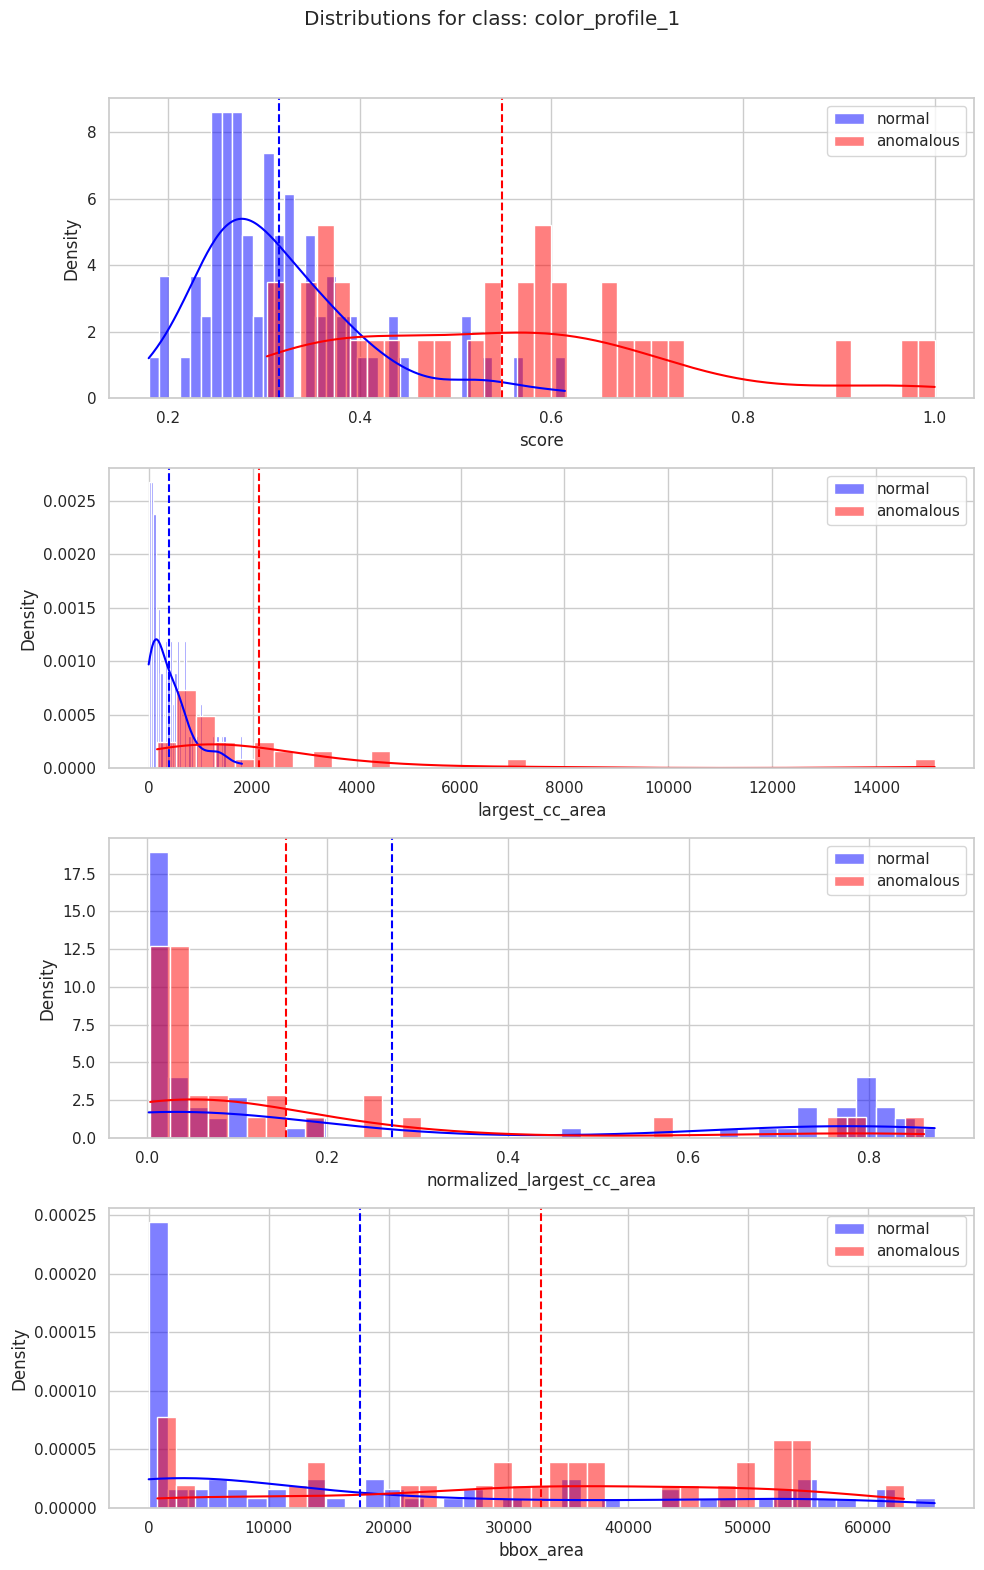

In [6]:
plot_metrics = ['score','largest_cc_area','normalized_largest_cc_area','bbox_area']
for cname, df in class_dfs.items():
    normal = df[df['gt_label']==0]
    anomalous = df[df['gt_label']==1]
    if df.empty:
        continue
    fig, axes = plt.subplots(len(plot_metrics), 1, figsize=(10, 4*len(plot_metrics)))
    fig.suptitle(f'Distributions for class: {cname}')
    for ax, metric in zip(axes, plot_metrics):
        if metric not in df.columns:
            ax.set_visible(False)
            continue
        sns.histplot(normal[metric].dropna(), ax=ax, color='blue', stat='density', bins=40, label='normal', kde=True, alpha=0.5)
        sns.histplot(anomalous[metric].dropna(), ax=ax, color='red', stat='density', bins=40, label='anomalous', kde=True, alpha=0.5)
        ax.set_xlabel(metric)
        ax.legend()
        # annotate means
        ax.axvline(normal[metric].dropna().mean(), color='blue', linestyle='--')
        ax.axvline(anomalous[metric].dropna().mean(), color='red', linestyle='--')
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.savefig(output_dir / f'{cname}_distributions.png')
    plt.show()


## Section 7: Boxplots and Violin plots for area metrics
Compare spread and outliers between normal and anomalous subsets.

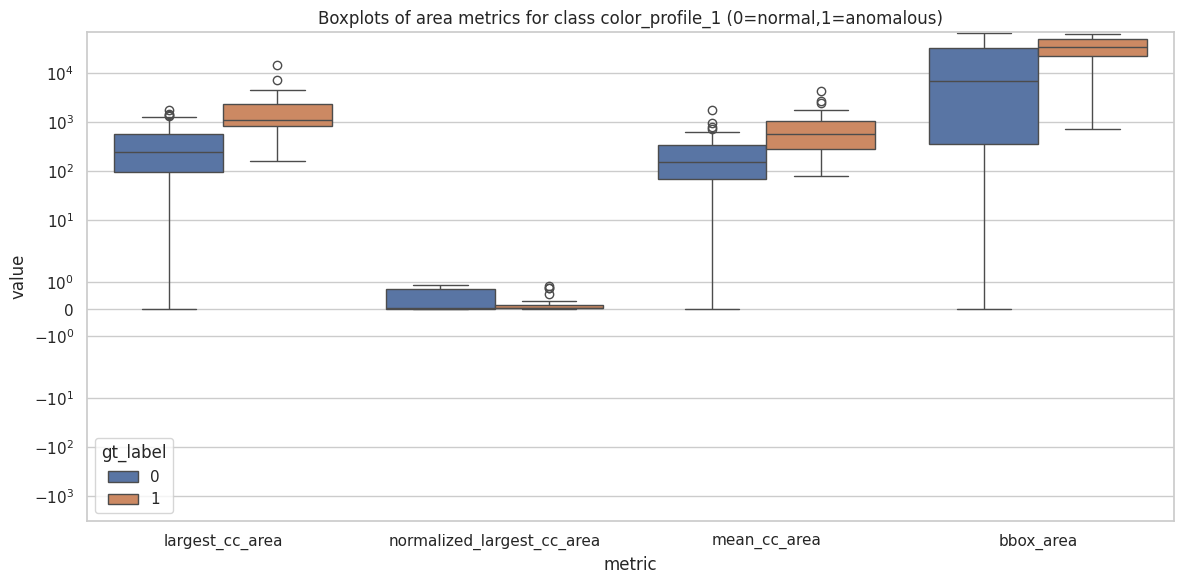

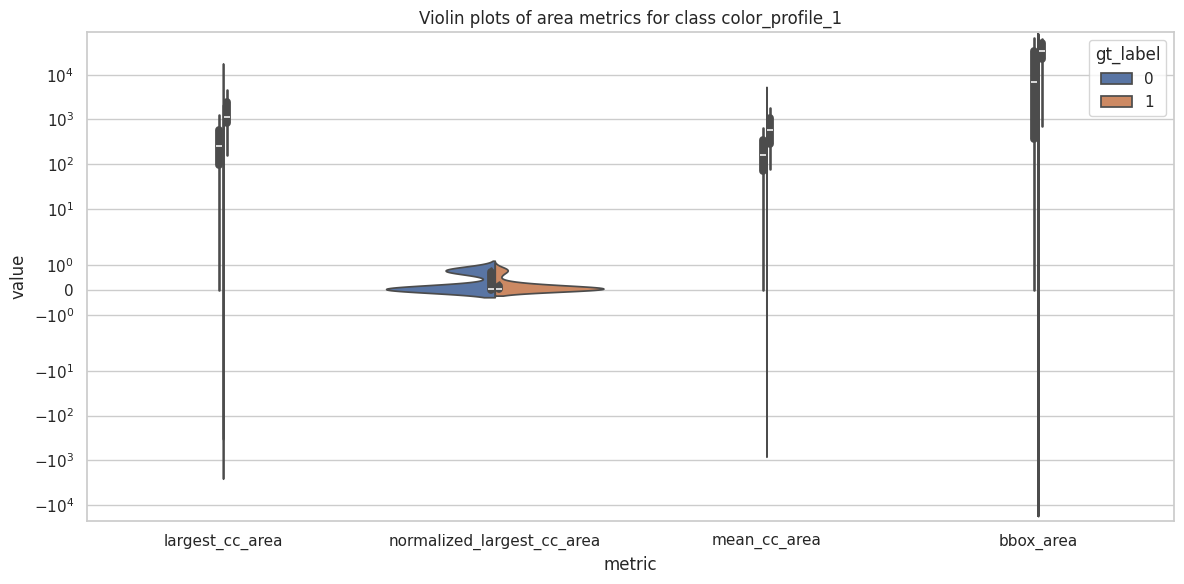

In [7]:
area_metrics = ['largest_cc_area','normalized_largest_cc_area','mean_cc_area','bbox_area']
for cname, df in class_dfs.items():
    if df.empty:
        continue
    melted = df.melt(id_vars=['filepath','gt_label'], value_vars=[m for m in area_metrics if m in df.columns], var_name='metric', value_name='value')
    plt.figure(figsize=(12,6))
    sns.boxplot(x='metric', y='value', hue='gt_label', data=melted)
    plt.title(f'Boxplots of area metrics for class {cname} (0=normal,1=anomalous)')
    plt.yscale('symlog')
    plt.tight_layout()
    plt.savefig(output_dir / f'{cname}_area_boxplots.png')
    plt.show()

    plt.figure(figsize=(12,6))
    sns.violinplot(x='metric', y='value', hue='gt_label', data=melted, split=True)
    plt.title(f'Violin plots of area metrics for class {cname}')
    plt.yscale('symlog')
    plt.tight_layout()
    plt.savefig(output_dir / f'{cname}_area_violins.png')
    plt.show()


## Section 8: Side-by-side means with error bars
Bar charts showing per-class mean +/- SEM for selected metrics.

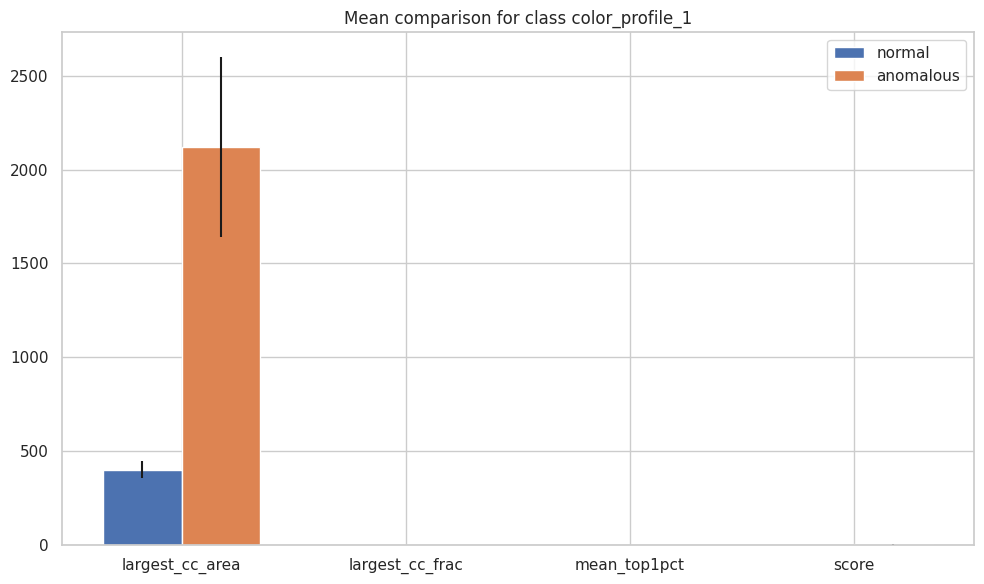

In [8]:
# Side-by-side means for selected metrics
summary_to_plot = per_class_summary_df[per_class_summary_df['metric'].isin(['largest_cc_area','largest_cc_frac','mean_top1pct','score'])]
for cname in per_class_summary_df['class'].unique():
    sub = summary_to_plot[summary_to_plot['class']==cname]
    if sub.empty:
        continue
    pivot = sub.pivot(index='metric', columns='class_label', values=['mean','sem'])
    # Plot grouped bars
    metrics_list = pivot.index.tolist()
    x = np.arange(len(metrics_list))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10,6))
    # Means
    means_normal = pivot[('mean','normal')].values
    means_anom = pivot[('mean','anomalous')].values
    sem_normal = pivot[('sem','normal')].values
    sem_anom = pivot[('sem','anomalous')].values
    ax.bar(x - width/2, means_normal, width, yerr=sem_normal, label='normal')
    ax.bar(x + width/2, means_anom, width, yerr=sem_anom, label='anomalous')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_list)
    ax.set_title(f'Mean comparison for class {cname}')
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_dir / f'{cname}_means_comparison.png')
    plt.show()


## Section 9: Scatter plots (score vs area metrics)
Scatter plots with regression lines per class and marginal histograms.

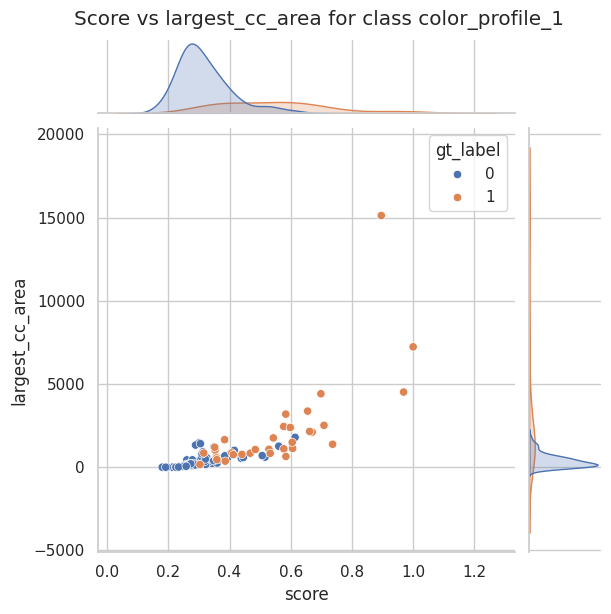

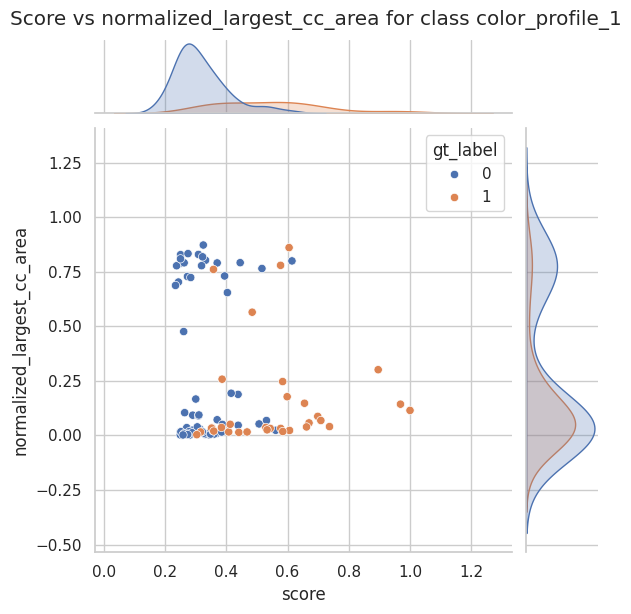

In [9]:
scatter_metrics = ['largest_cc_area','normalized_largest_cc_area']
for cname, df in class_dfs.items():
    if df.empty:
        continue
    for metric in scatter_metrics:
        if metric not in df.columns:
            continue
        sns.jointplot(x='score', y=metric, data=df, kind='scatter', hue='gt_label')
        plt.suptitle(f'Score vs {metric} for class {cname}', y=1.02)
        plt.savefig(output_dir / f'{cname}_score_vs_{metric}.png')
        plt.show()


## Section 10: Correlation matrices and heatmaps
Compute Pearson correlation matrices for numeric features per subset and plot heatmaps.

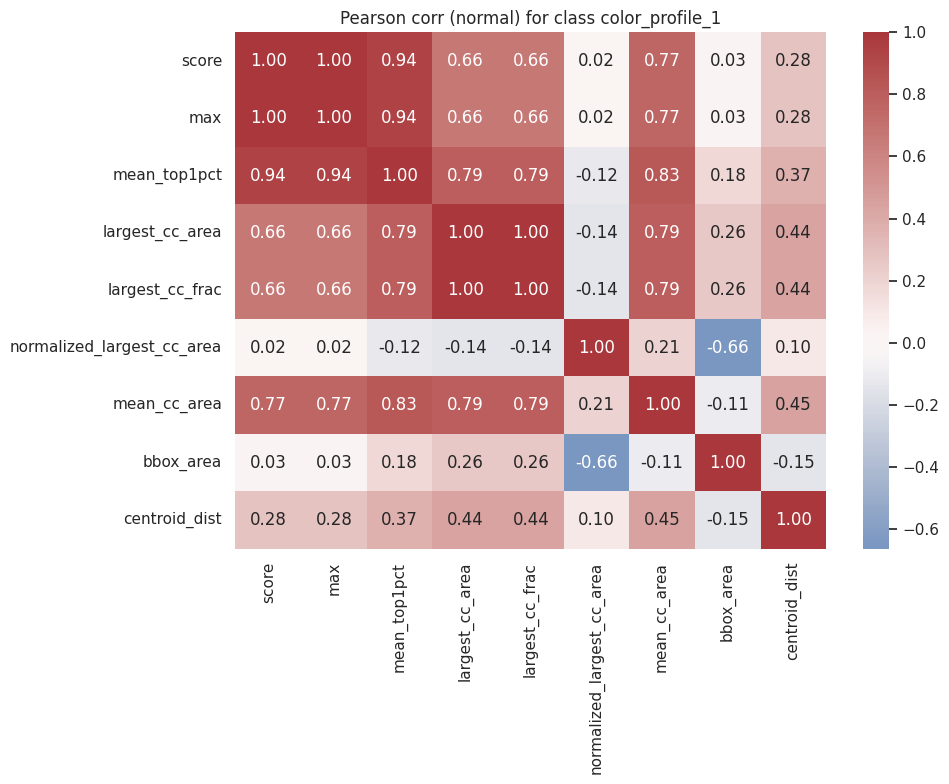

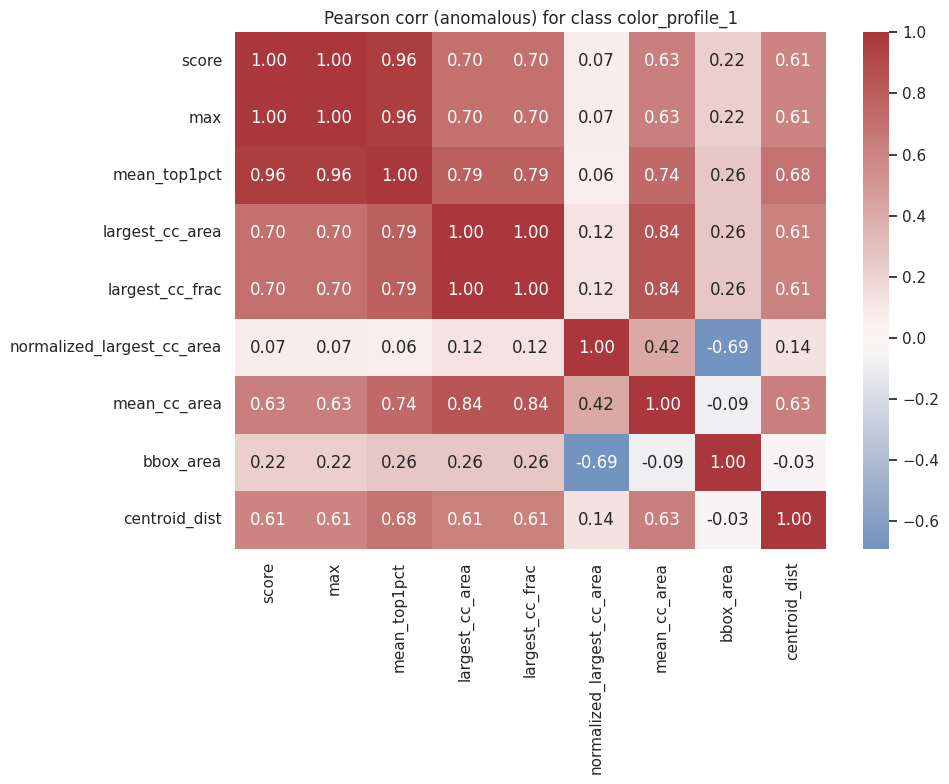

In [10]:
corr_metrics = ['score','max','mean_top1pct','largest_cc_area','largest_cc_frac','normalized_largest_cc_area','mean_cc_area','bbox_area','centroid_dist']
for cname, df in class_dfs.items():
    if df.empty:
        continue
    normal = df[df['gt_label']==0][corr_metrics].dropna()
    anomalous = df[df['gt_label']==1][corr_metrics].dropna()
    for label, subset in [('normal', normal), ('anomalous', anomalous)]:
        if subset.shape[0] < 3:
            continue
        corr = subset.corr(method='pearson')
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
        plt.title(f'Pearson corr ({label}) for class {cname}')
        plt.tight_layout()
        plt.savefig(output_dir / f'{cname}_corr_{label}.png')
        plt.show()


## Section 11: Statistical tests between classes
Run t-test and Mann–Whitney U test per metric and correct p-values with Benjamini–Hochberg.

In [11]:
from statsmodels.stats.multitest import multipletests

stat_results = []
for cname, df in class_dfs.items():
    if df.empty:
        continue
    normal = df[df['gt_label']==0]
    anomalous = df[df['gt_label']==1]
    for metric in corr_metrics:
        if metric not in df.columns:
            continue
        a_vals = normal[metric].dropna().values
        b_vals = anomalous[metric].dropna().values
        if len(a_vals) < 2 or len(b_vals) < 2:
            stat_results.append({'class': cname, 'metric': metric, 't_stat': np.nan, 't_p': np.nan, 'mw_stat': np.nan, 'mw_p': np.nan})
            continue
        try:
            t_stat, t_p = stats.ttest_ind(a_vals, b_vals, equal_var=False, nan_policy='omit')
        except Exception:
            t_stat, t_p = np.nan, np.nan
        try:
            mw_stat, mw_p = stats.mannwhitneyu(a_vals, b_vals, alternative='two-sided')
        except Exception:
            mw_stat, mw_p = np.nan, np.nan
        stat_results.append({'class': cname, 'metric': metric, 't_stat': t_stat, 't_p': t_p, 'mw_stat': mw_stat, 'mw_p': mw_p})

stat_df = pd.DataFrame(stat_results)
# Multiple testing correction per class across metrics
corrections = []
for cname in stat_df['class'].unique():
    subset = stat_df[stat_df['class']==cname]
    pvals = subset['mw_p'].fillna(1.0).values
    reject, pvals_corr, _, _ = multipletests(pvals, method='fdr_bh')
    corrections.extend(list(pvals_corr))

stat_df['mw_p_adj'] = corrections
stat_df.to_csv(output_dir / 'stat_tests_per_class.csv', index=False)
stat_df.head()


,class,metric,t_stat,t_p,mw_stat,mw_p,mw_p_adj
0,color_profile_1,score,-7.023948,2.117520e-08,238.0,2.687017e-11,8.061051e-11
1,color_profile_1,max,-7.023948,2.117520e-08,238.0,2.687017e-11,8.061051e-11
2,color_profile_1,mean_top1pct,-6.577781,1.103544e-07,212.0,8.133142e-12,7.319827e-11
3,color_profile_1,largest_cc_area,-3.571103,1.128461e-03,256.0,6.004296e-11,1.080773e-10
4,color_profile_1,largest_cc_frac,-3.571103,1.128461e-03,256.0,6.004296e-11,1.080773e-10


## Section 12: ROC curve and AUC
Use `score` as predictor for `gt_label`. Compute ROC, AUC and plot confusion matrix at optimal threshold (Youden's J).

Class color_profile_1: AUC=0.9038, optimal_threshold=0.3515


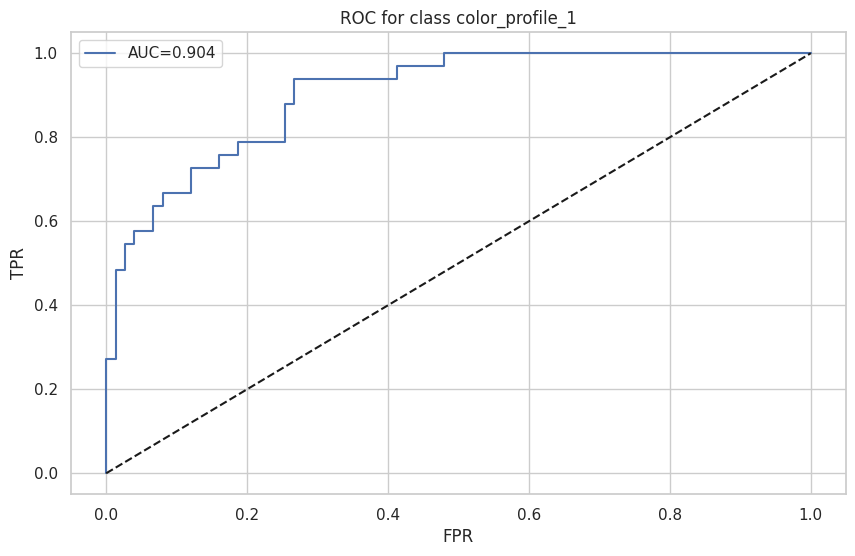

Confusion matrix at opt threshold: {'tn': np.int64(55), 'fp': np.int64(20), 'fn': np.int64(2), 'tp': np.int64(31)}
Saved per_class_summary_with_thresholds.csv


In [12]:
for cname, df in class_dfs.items():
    if 'score' not in df.columns or df.empty:
        continue
    y_true = df['gt_label'].values
    y_score = df['score'].values
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    # Youden's J statistic
    j_scores = tpr - fpr
    j_idx = np.argmax(j_scores)
    opt_thr = thresholds[j_idx]
    print(f'Class {cname}: AUC={roc_auc:.4f}, optimal_threshold={opt_thr:.4f}')
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title(f'ROC for class {cname}')
    plt.legend()
    plt.savefig(output_dir / f'{cname}_roc.png')
    plt.show()

    # Confusion matrix at opt threshold
    preds = (y_score >= opt_thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    print('Confusion matrix at opt threshold:', dict(tn=tn, fp=fp, fn=fn, tp=tp))
    
    # Save threshold to summary df
    per_class_summary_df.loc[per_class_summary_df['class']==cname, 'optimal_threshold'] = opt_thr

per_class_summary_df.to_csv(output_dir / 'per_class_summary_with_thresholds.csv', index=False)
print('Saved per_class_summary_with_thresholds.csv')


## Section 13: Export summaries and example FP/FN lists
Save CSVs and lists of example false positives and false negatives for manual inspection.

In [13]:
# Export per_class_summary_df
per_class_summary_df.to_csv(output_dir / 'per_class_summary_final.csv', index=False)
print('Saved per_class_summary_final.csv')

# Save FP and FN examples per class
for cname, df in class_dfs.items():
    if df.empty:
        continue
    fp = df[(df['gt_label']==0) & (df['pred_label']==1)]
    fn = df[(df['gt_label']==1) & (df['pred_label']==0)]
    with open(output_dir / f'{cname}_fp_examples.txt','w') as f:
        for p in fp['filepath'].tolist():
            f.write(p + '\n')
    with open(output_dir / f'{cname}_fn_examples.txt','w') as f:
        for p in fn['filepath'].tolist():
            f.write(p + '\n')
    print(f'Class {cname}: saved {len(fp)} FP and {len(fn)} FN examples')

print('All outputs saved to', output_dir)


Saved per_class_summary_final.csv
Class color_profile_1: saved 20 FP and 2 FN examples
All outputs saved to results/256_color_profile_1/analysis_outputs
